In [23]:
# !pip install uharfbuzz freetype-py
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import math
import numpy as np
import freetype
import uharfbuzz as hb


In [24]:
FONT_SIZE=35
COL_NUM=8

In [25]:
all_subdirs = [d for d in Path('./fonts/').iterdir() if d.is_dir()]

In [26]:
all_fonts = []
for d in all_subdirs:
    d_otfs = list(d.rglob('*.otf'))
    d_ttfs = list(d.rglob('*.ttf'))
    
    for font in d_otfs + d_ttfs:
        try:
            ImageFont.truetype(font, size=FONT_SIZE)
            all_fonts.append(font)
        except:
            print(font)
    


In [46]:
!pip install uharfbuzz freetype-py cairocffi python-bidi

     |████████████████████████████████| 269 kB 233 kB/s eta 0:00:01


In [48]:
!brew install cairo

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
Error: Cannot install under Rosetta 2 in ARM default prefix (/opt/homebrew)!
To rerun under ARM use:
    arch -arm64 brew install ...
To install under x86_64, install Homebrew into /usr/local.


In [47]:
import cairocffi as cairo
import freetype
import uharfbuzz as hb
from PIL import Image
from bidi.algorithm import get_display

def calculate_stride(width, format=cairo.FORMAT_A8):
    bpp = 1  # bytes per pixel for FORMAT_A8
    stride = width * bpp
    if stride % 4 != 0:
        stride += 4 - (stride % 4)
    return stride

def create_glyph_surface(bitmap):
    width, rows = bitmap.width, bitmap.rows
    stride = calculate_stride(width, cairo.FORMAT_A8)

    glyph_data = bytearray(stride * rows)
    pitch = abs(bitmap.pitch)

    for row in range(rows):
        start_src = row * pitch
        start_dst = row * stride
        row_data = bitmap.buffer[start_src:start_src + width]
        glyph_data[start_dst:start_dst + width] = row_data

    glyph_surface = cairo.ImageSurface.create_for_data(
        glyph_data,
        cairo.FORMAT_A8,
        width,
        rows,
        stride,
    )
    return glyph_surface, glyph_data

def render_text_harfbuzz_to_pil(text, fontfile, font_size=32, color=(0, 0, 0)):
    face = freetype.Face(fontfile)
    face.set_char_size(font_size * 64)

    with open(fontfile, "rb") as f:
        fontdata = f.read()

    hb_face = hb.Face(fontdata, 0)
    hb_font = hb.Font(hb_face)
    hb_font.scale = (face.size.height, face.size.height)

    buf = hb.Buffer()
    
    buf.add_str(get_display(text)[::-1])
    buf.guess_segment_properties()

    hb.shape(hb_font, buf)
    infos = buf.glyph_infos
    positions = buf.glyph_positions

    width = sum((pos.x_advance for pos in positions)) / 64
    height = font_size * 1.5

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, int(width) + 20, int(height) + 20)
    ctx = cairo.Context(surface)

    # White background
    ctx.set_source_rgb(1, 1, 1)
    ctx.paint()

    # Set text color
    ctx.set_source_rgb(*color)

    x, y = 10, 20 + font_size

    glyph_surfaces = []
    glyph_datas = []

    for info, pos in zip(infos, positions):
        glyph_index = info.codepoint

        face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
        bitmap = face.glyph.bitmap
        top = face.glyph.bitmap_top
        left = face.glyph.bitmap_left

        if bitmap.width == 0 or bitmap.rows == 0:
            x += pos.x_advance / 64
            y -= pos.y_advance / 64
            continue

        glyph_surface, glyph_data = create_glyph_surface(bitmap)

        glyph_surfaces.append(glyph_surface)
        glyph_datas.append(glyph_data)

        ctx.save()
        ctx.translate(x + pos.x_offset / 64 + left, y - pos.y_offset / 64 - top)
        ctx.mask_surface(glyph_surface, 0, 0)
        ctx.restore()

        x += pos.x_advance / 64
        y -= pos.y_advance / 64

    # Convert cairo surface to PIL Image
    buf = surface.get_data()
    img = Image.frombuffer(
        "RGBA",
        (surface.get_width(), surface.get_height()),
        buf,
        "raw",
        "BGRA",
        0,
        1,
    )
    return img

OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': dlopen(libcairo.so.2, 0x0002): tried: '/Users/giladgoldreich/opt/anaconda3/lib/libcairo.so.2' (no such file), '/Users/giladgoldreich/opt/anaconda3/bin/../lib/libcairo.so.2' (no such file), 'libcairo.so.2' (no such file), '/usr/local/lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file), '/Users/giladgoldreich/Documents/675/document_ocr/hebrew/libcairo.so.2' (no such file), '/usr/local/lib/libcairo.so.2' (no such file), '/usr/lib/libcairo.so.2' (no such file).  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.so.2'
cannot load library 'libcairo.2.dylib': dlopen(libcairo.2.dylib, 0x0002): tried: '/Users/giladgoldreich/opt/anaconda3/lib/libcairo.2.dylib' (no such file), '/Users/giladgoldreich/opt/anaconda3/bin/../lib/libcairo.2.dylib' (no such file), 'libcairo.2.dylib' (no such file), '/usr/local/lib/libcairo.2.dylib' (no such file), '/usr/lib/libcairo.2.dylib' (no such file), '/Users/giladgoldreich/Documents/675/document_ocr/hebrew/libcairo.2.dylib' (no such file), '/usr/local/lib/libcairo.2.dylib' (no such file), '/usr/lib/libcairo.2.dylib' (no such file).  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.2.dylib'
cannot load library 'libcairo-2.dll': dlopen(libcairo-2.dll, 0x0002): tried: '/Users/giladgoldreich/opt/anaconda3/lib/libcairo-2.dll' (no such file), '/Users/giladgoldreich/opt/anaconda3/bin/../lib/libcairo-2.dll' (no such file), 'libcairo-2.dll' (no such file), '/usr/local/lib/libcairo-2.dll' (no such file), '/usr/lib/libcairo-2.dll' (no such file), '/Users/giladgoldreich/Documents/675/document_ocr/hebrew/libcairo-2.dll' (no such file), '/usr/local/lib/libcairo-2.dll' (no such file), '/usr/lib/libcairo-2.dll' (no such file).  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo-2.dll'

In [53]:
from PIL import Image, ImageDraw
import freetype
import uharfbuzz as hb
from bidi import get_display

def render_hebrew_text(text, font_path, font_size=48, color=(0, 0, 0), bg_color=(255, 255, 255)):
    face = freetype.Face(font_path)
    face.set_char_size(font_size * 64)
    
    fontdata = open(font_path, 'rb').read()
    hb_font = hb.Font(hb.Face(fontdata))
    hb_font.scale = (face.size.height, face.size.height)

    buf = hb.Buffer()
    buf.add_str(get_display(text)[::-1])
    # buf.direction = "rtl"
    # buf.language = "he"
    buf.guess_segment_properties()
    hb.shape(hb_font, buf)

    infos = buf.glyph_infos
    positions = buf.glyph_positions

    # Track bounding box
    x, y = 0, 0
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')

    # Pass 1: calculate bounding box
    pen_x, pen_y = 0, 0
    for info, pos in zip(infos, positions):
        glyph_index = info.codepoint
        dx = pos.x_offset / 64
        dy = -pos.y_offset / 64

        face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
        bitmap = face.glyph.bitmap
        top = face.glyph.bitmap_top
        left = face.glyph.bitmap_left

        x0 = pen_x + left + dx
        y0 = pen_y - top + dy
        x1 = x0 + bitmap.width
        y1 = y0 + bitmap.rows

        min_x = min(min_x, x0)
        max_x = max(max_x, x1)
        min_y = min(min_y, y0)
        max_y = max(max_y, y1)

        pen_x += pos.x_advance / 64
        pen_y += pos.y_advance / 64

    width = int(max_x - min_x + 20)
    height = int(max_y - min_y + 20)
    offset_x = -min_x + 10
    offset_y = -min_y + 10

    # Create image
    img = Image.new("RGB", (width, height), bg_color)
    
    # Pass 2: draw glyphs
    pen_x, pen_y = 0, 0
    for info, pos in zip(infos, positions):
        glyph_index = info.codepoint
        dx = pos.x_offset / 64
        dy = -pos.y_offset / 64

        face.load_glyph(glyph_index, freetype.FT_LOAD_RENDER)
        bitmap = face.glyph.bitmap
        top = face.glyph.bitmap_top
        left = face.glyph.bitmap_left

        if bitmap.width > 0 and bitmap.rows > 0:
            glyph_img = Image.frombytes("L", (bitmap.width, bitmap.rows), bytes(bitmap.buffer))
            glyph_colored = Image.new("RGB", glyph_img.size, color)
            img.paste(glyph_colored, (int(pen_x + left + dx + offset_x), int(pen_y - top + dy + offset_y)), glyph_img)

        pen_x += pos.x_advance / 64
        pen_y += pos.y_advance / 64
    
    return img



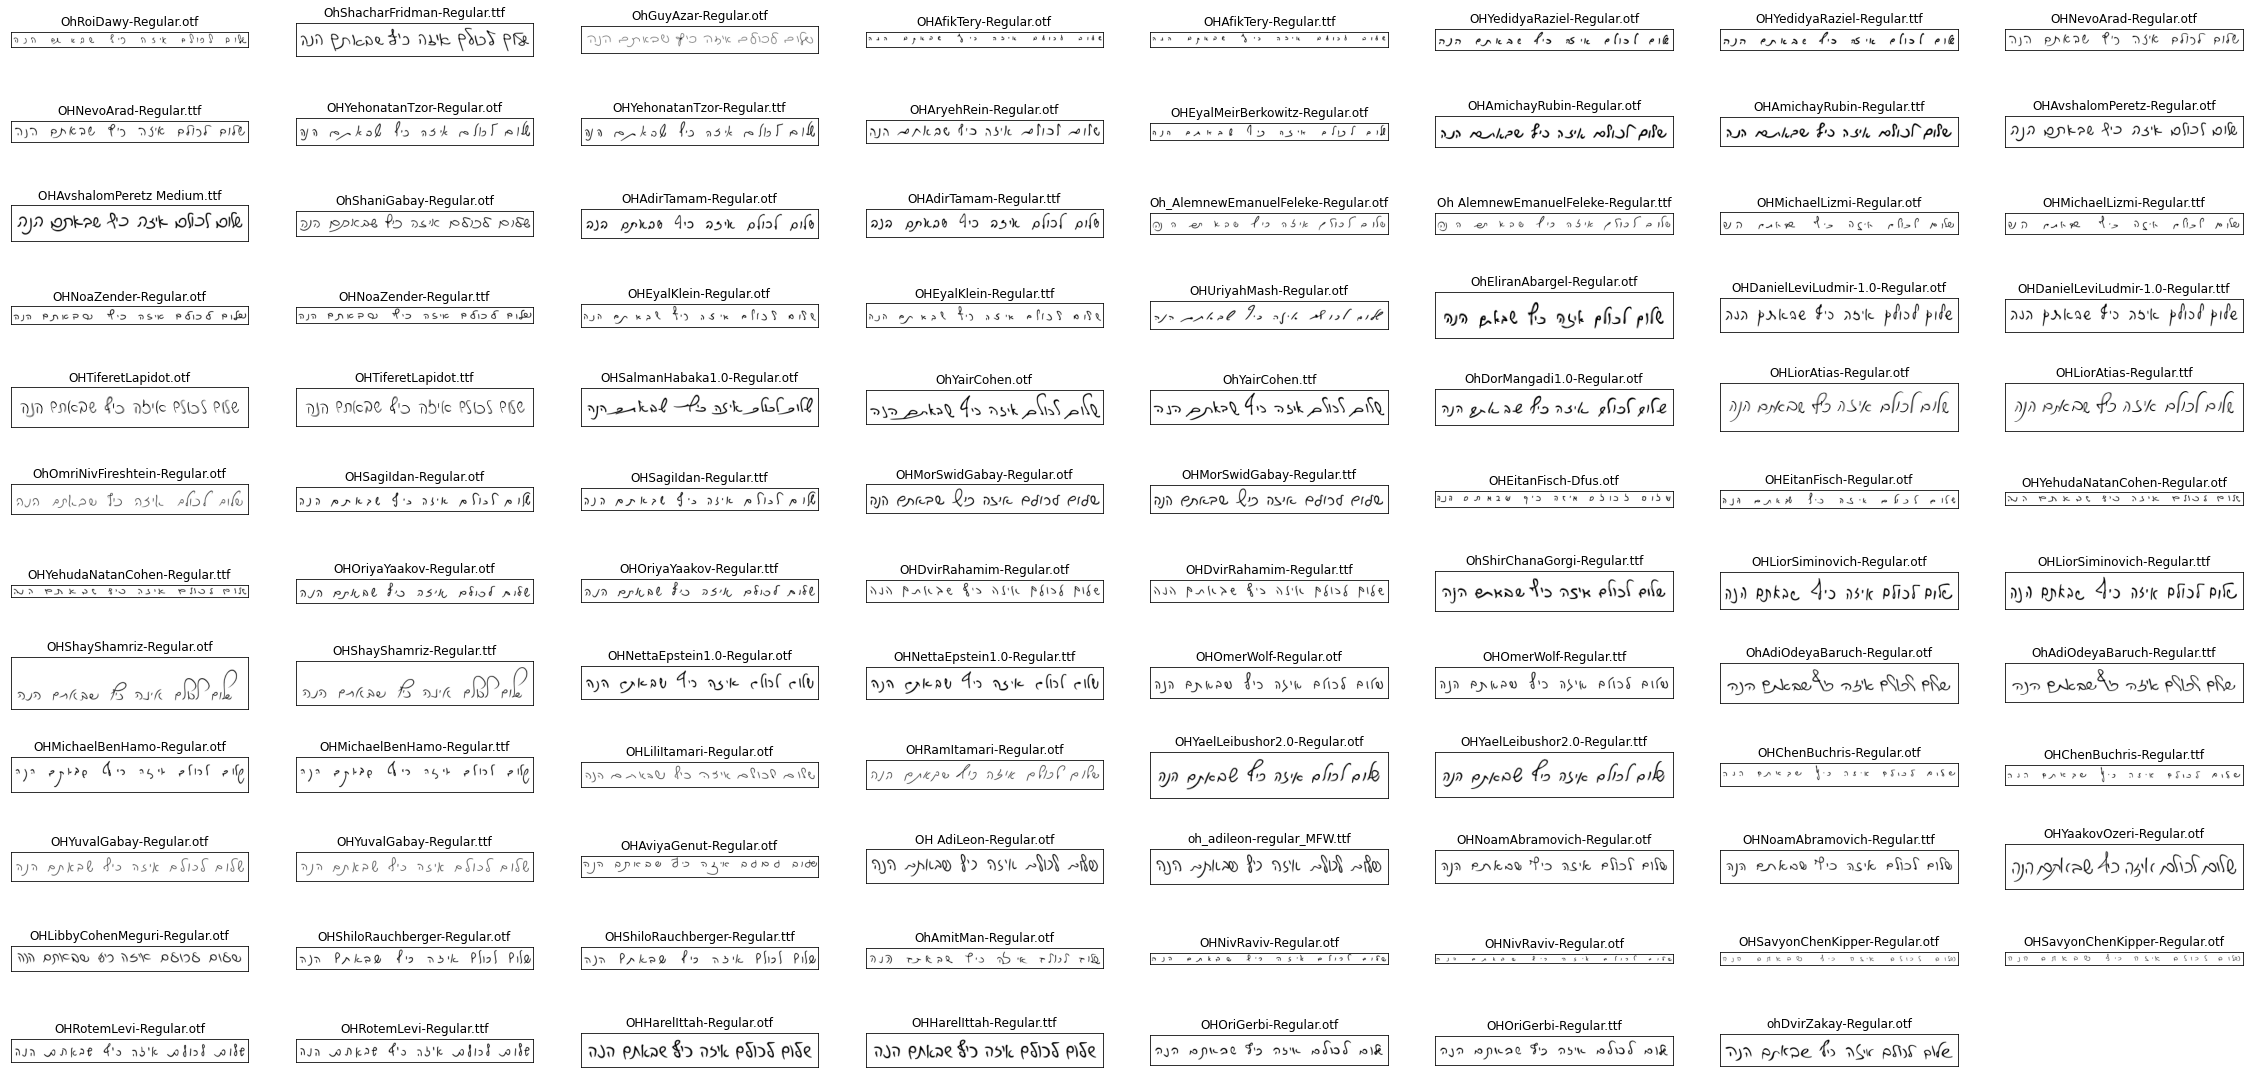

In [55]:
txt = 'שלום לכולם איזה כיף שבאתם הנה'
fig, axes = plt.subplots(nrows=math.ceil(len(all_fonts)/COL_NUM), ncols=COL_NUM, figsize=(40, 20))
row_indices, col_indices = np.unravel_index(range(np.prod(axes.shape)), axes.shape)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
for i, font_file in enumerate(all_fonts):
    
    ax = axes[row_indices[i], col_indices[i]]
    ax.set_title(font_file.name)
    font = ImageFont.truetype(font_file, size=FONT_SIZE)
    box = font.getbbox(txt)
    
    im = render_hebrew_text(txt, str(font_file), FONT_SIZE)
    ax.imshow(im)

for i in range(len(all_fonts), np.prod(axes.shape)):
    ax = axes[row_indices[i], col_indices[i]]
    ax.remove()
    

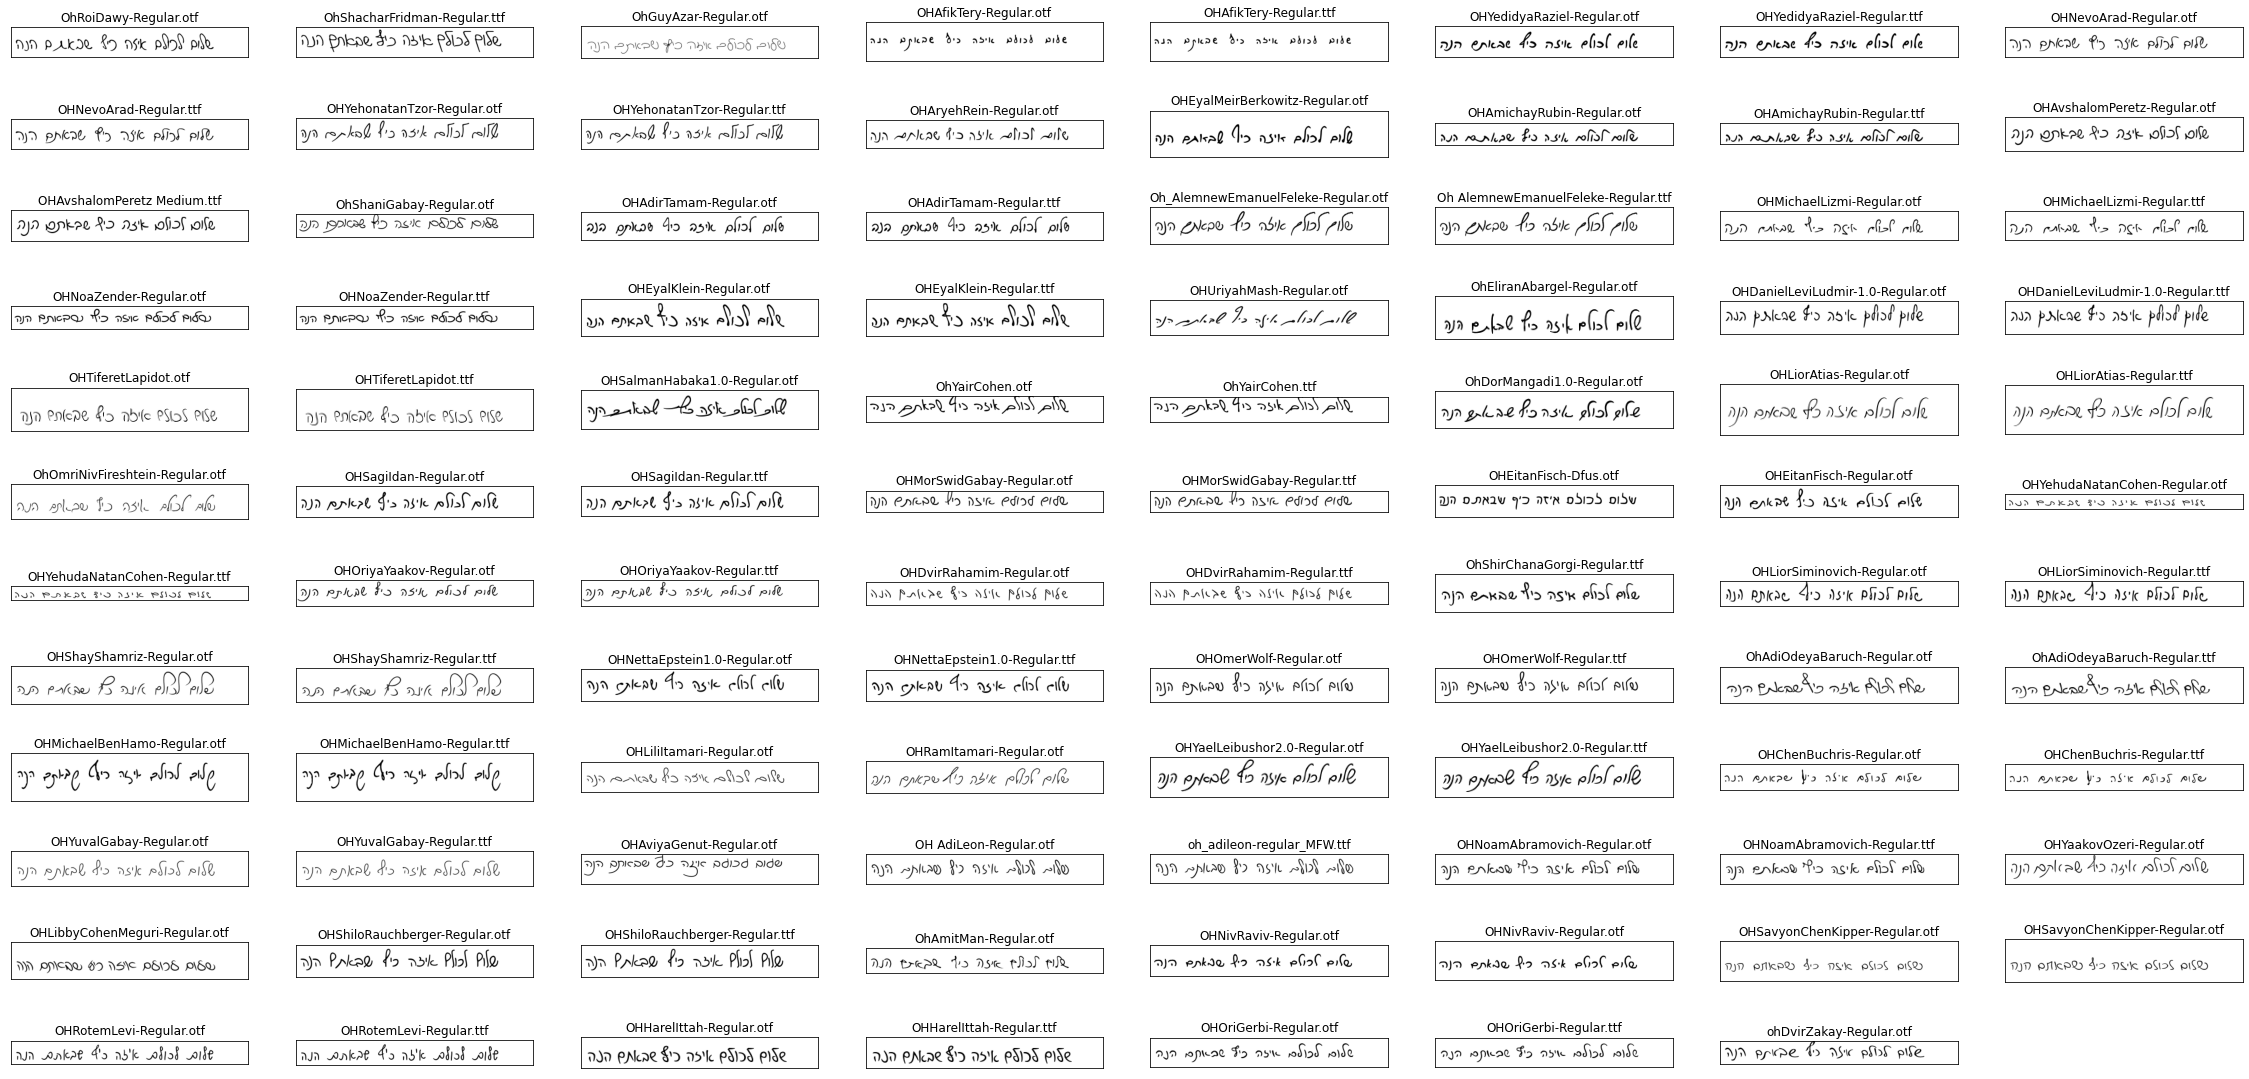

In [65]:
stroke_width = 0
fig, axes = plt.subplots(nrows=math.ceil(len(all_fonts)/COL_NUM), ncols=COL_NUM, figsize=(40, 20))
row_indices, col_indices = np.unravel_index(range(np.prod(axes.shape)), axes.shape)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
for i, font_file in enumerate(all_fonts):
    
    ax = axes[row_indices[i], col_indices[i]]
    ax.set_title(font_file.name)
    font = ImageFont.truetype(font_file, size=FONT_SIZE)
    box = font.getbbox(txt, stroke_width=stroke_width)
    im = Image.new('RGB', (int(1.2*box[2]), int(1.5*box[3])), color='white')
    ImageDraw.Draw(im).text((10, 10), txt[::-1], outline='black', fill='black', font=font, stroke_width=stroke_width)
    
    # im = render_hebrew_text(txt, str(font_file), FONT_SIZE)
    ax.imshow(im)

for i in range(len(all_fonts), np.prod(axes.shape)):
    ax = axes[row_indices[i], col_indices[i]]
    ax.remove()
    